#### <b> Abalome Age Prediction </b>

### Overview


#### <b> Importing the Libraries </b>

In [1]:
!pip install tqdm==4.66.2

In [199]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import Linear, BatchNorm1d, ReLU, MSELoss
from torch.optim import SGD
from tqdm import tqdm

#### <b> Data Loading</b>

In [9]:
train_data=None
test_data=None
for dirname, _, filenames in os.walk('../datasets'):
    for file in filenames:
        if file == 'train.csv':
            train_path = os.path.join(dirname, file)
            train_data= pd.read_csv(f'{train_path}')
        elif file == 'test.csv':
            test_path = os.path.join(dirname, file)
            test_data= pd.read_csv(f'{test_path}')
print('Data Loading .........................................................')
print('--'*int(1e3))
print('Complete')

Data Loading .........................................................
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### <b> Data Preprocessing </b>

In [10]:
#displaying the first 5 rows
train_data.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [11]:
len(train_data)

90615

In [12]:
#test data
test_data.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


2. General Information

In [13]:
train_data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Columns: 10 entries, id to Rings
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


Inferences:
1. The Dataset consist of 10 Features, with 9 been Numerical and 1 been Categorical
2. The Id Feaures serves as a unique identifier. So it will be dropped.

3. Overall Statistics

In [14]:
train_data.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [15]:
#dropping the id feature
train_data.drop('id', axis=1, inplace=True)

In [16]:
train_data.sample()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
73050,I,0.61,0.47,0.16,1.0295,0.419,0.204,0.32,12


4. Checking for Null Values

In [17]:
null_df_train =pd.DataFrame(
    {
        'Features': [col for col in train_data.columns],
        'Null Values': [train_data[col].isna().sum() for col in train_data.columns],
        'Duplicate Values': [train_data.duplicated().sum() for col in train_data.columns]
    }
)
null_df_train

,Features,Null Values,Duplicate Values
0,Sex,0,0
1,Length,0,0
2,Diameter,0,0
3,Height,0,0
4,Whole weight,0,0
5,Whole weight.1,0,0
6,Whole weight.2,0,0
7,Shell weight,0,0
8,Rings,0,0


In [18]:
null_df_test =pd.DataFrame(
    {
        'Features': [col for col in test_data.columns],
        'Null Values': [test_data[col].isna().sum() for col in test_data.columns],
        'Duplicate Values': [test_data.duplicated().sum() for col in test_data.columns]
    }
)
null_df_test

,Features,Null Values,Duplicate Values
0,id,0,0
1,Sex,0,0
2,Length,0,0
3,Diameter,0,0
4,Height,0,0
5,Whole weight,0,0
6,Whole weight.1,0,0
7,Whole weight.2,0,0
8,Shell weight,0,0


Inferences:
1. There are no Missing Values in the Data.
2. There are No Duplicate Values in the Data.

#### <b> EDA</b>

In [19]:
train_data['Sex'].value_counts()

Sex
I    33093
M    31027
F    26495
Name: count, dtype: int64

1. Categorcal Features Data-Viz

In [38]:
train_data['Sex']= train_data['Sex'].map({
    'I': 'Unknown',
    'M':'Male',
    'F':'Female'
})

train_data['Sex'].value_counts()

Sex
Unknown    33093
Male       31027
Female     26495
Name: count, dtype: int64

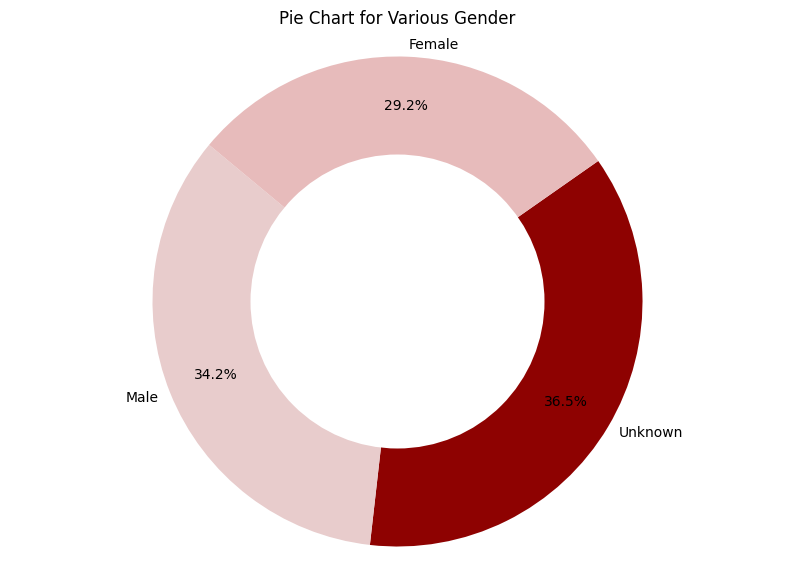

In [39]:
counts = train_data['Sex'].value_counts(normalize=True)*100
labels= ['Unknown', "Male", 'Female']
colors =  ['#8e0201', '#e8cccc', '#e7bbbb']
plt.figure(figsize=(10,7))

#plotting the pie chart
wedges, texts, autotexts = plt.pie(counts, colors=colors, startangle=35, counterclock=False, autopct='%1.1f%%',
                                  pctdistance=0.8, labeldistance=1.05, labels=labels)

#adding a centrer circle
centre_circle = plt.Circle((0,0), 0.60, fc='white')
plt.gca().add_artist(centre_circle)


plt.axis('equal')
plt.title('Pie Chart for Various Gender')
plt.show()

2. Numerical Features Data-Viz

In [50]:
#selecting numerical columns
num_cols = train_data.select_dtypes(include=np.number).columns.tolist()

def scatter_plot(col_list):
    plt.figure(figsize=(20, 15))
    for idx, val in enumerate(col_list):
        plt.subplot(2, 2, idx + 1)
        colors = ['#8e0201', '#e8cccc', '#005b96']
        if val != 'Rings':
            sns.scatterplot(
                y=train_data[val],
                x=train_data["Rings"],  
                data=train_data,
                hue='Sex',
                palette=colors
            )

            plt.title(val) 
        else:
            plt.delaxes(plt.gca())  

    plt.tight_layout()  
    plt.show()

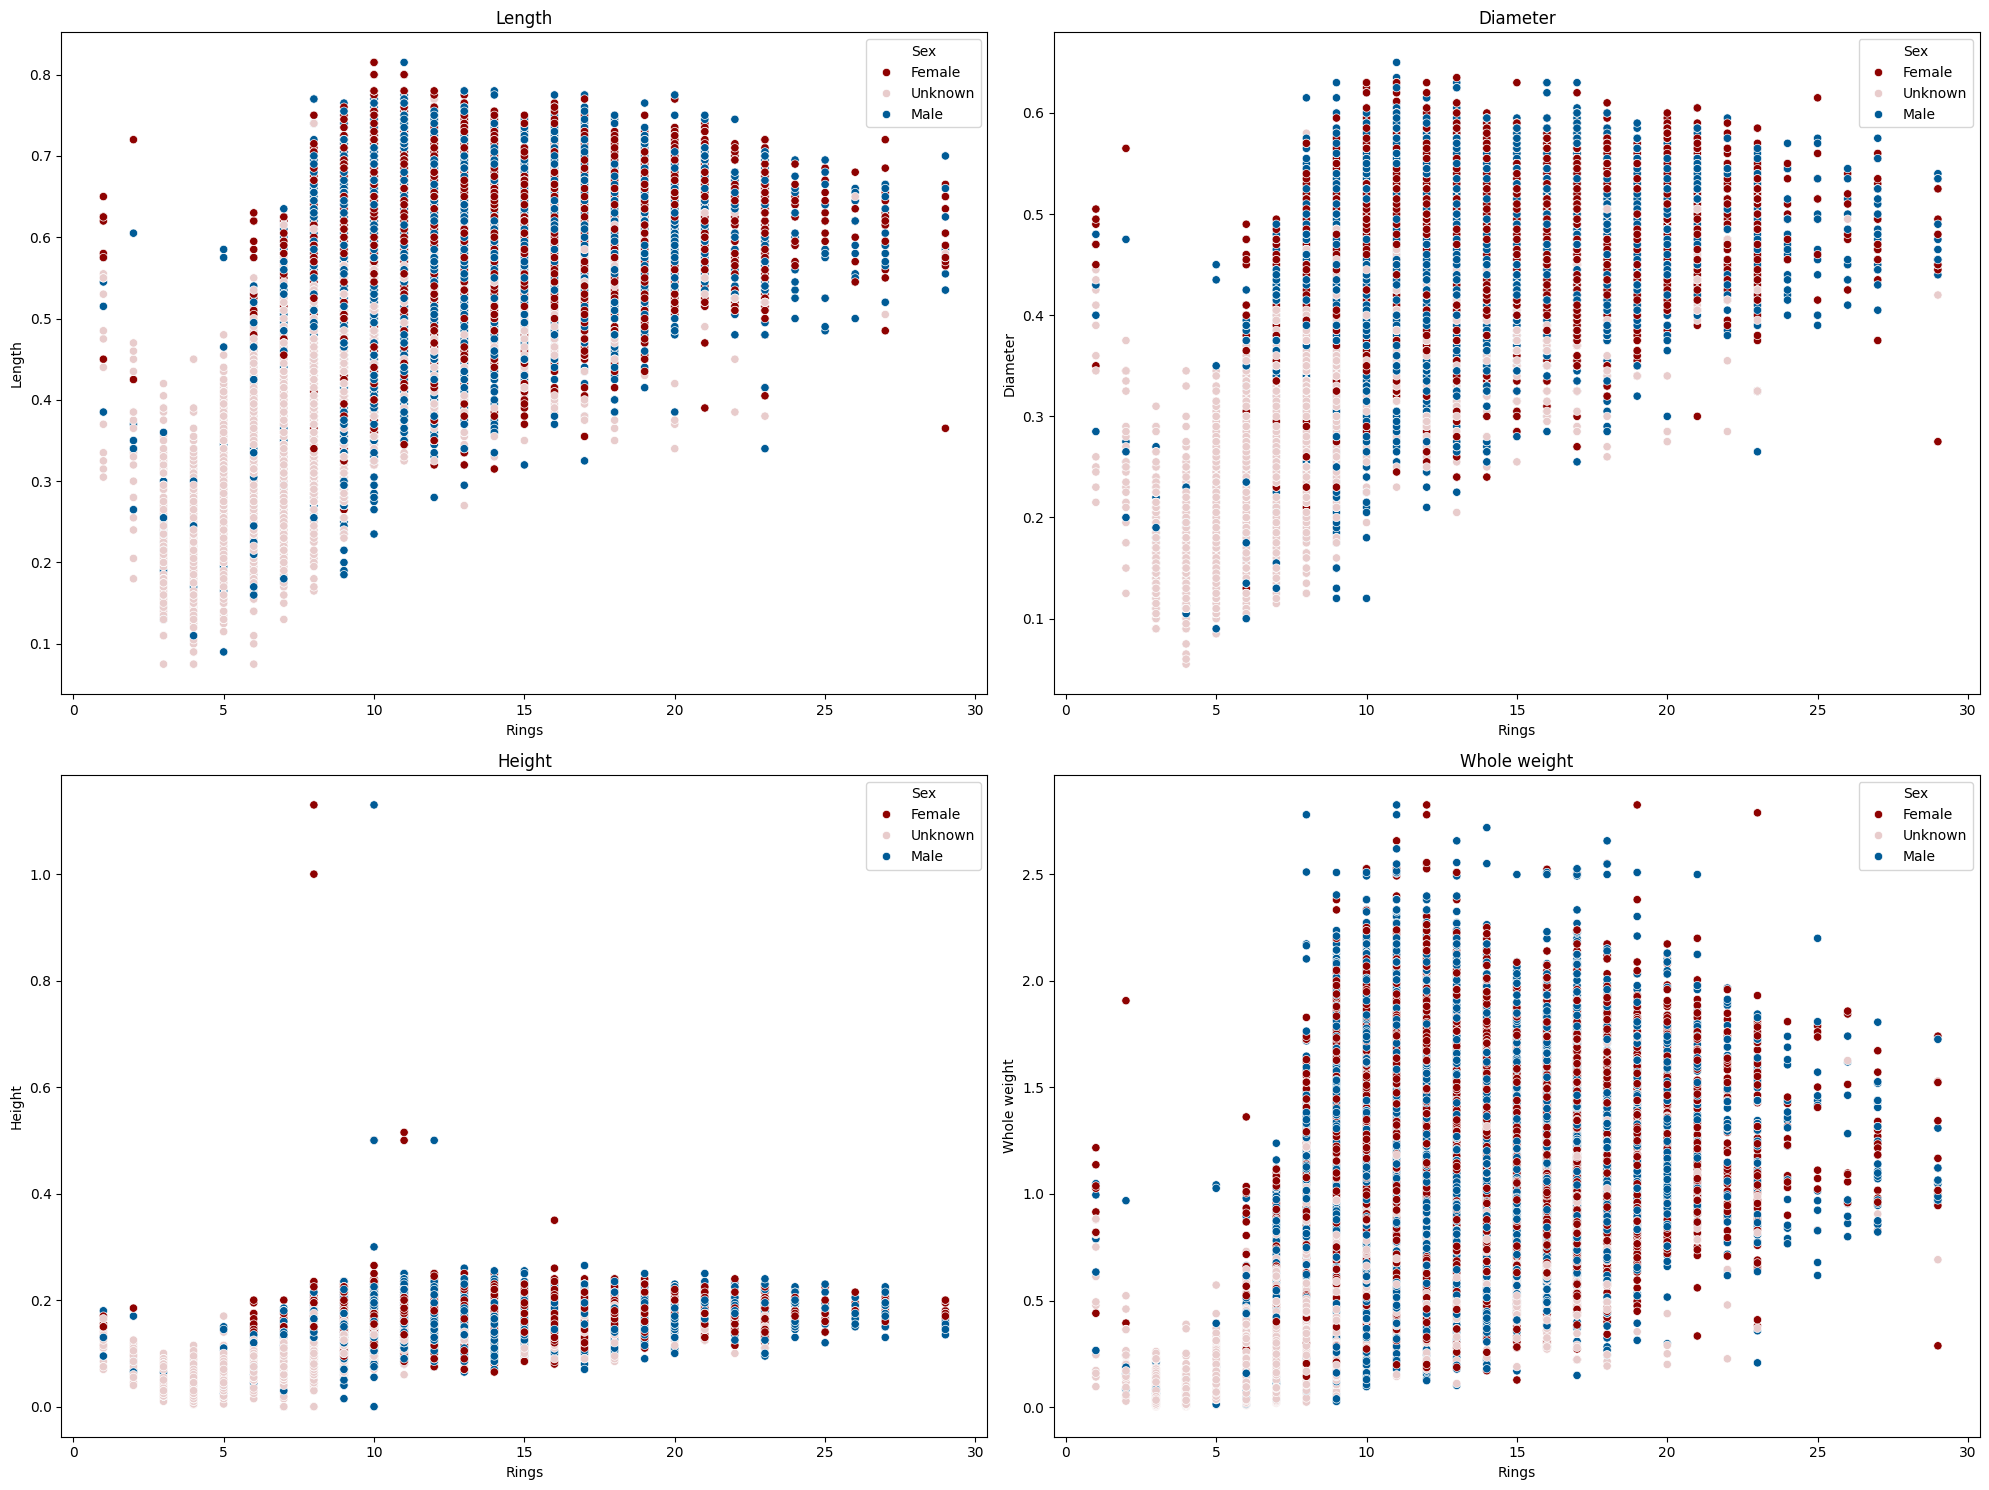

In [51]:
# Call the function with numerical columns list
scatter_plot(num_cols[0:4])

Inferences:
1. Features like Length, Diameter, Weight, and Height are have a strong positive relation with the Target Rings.


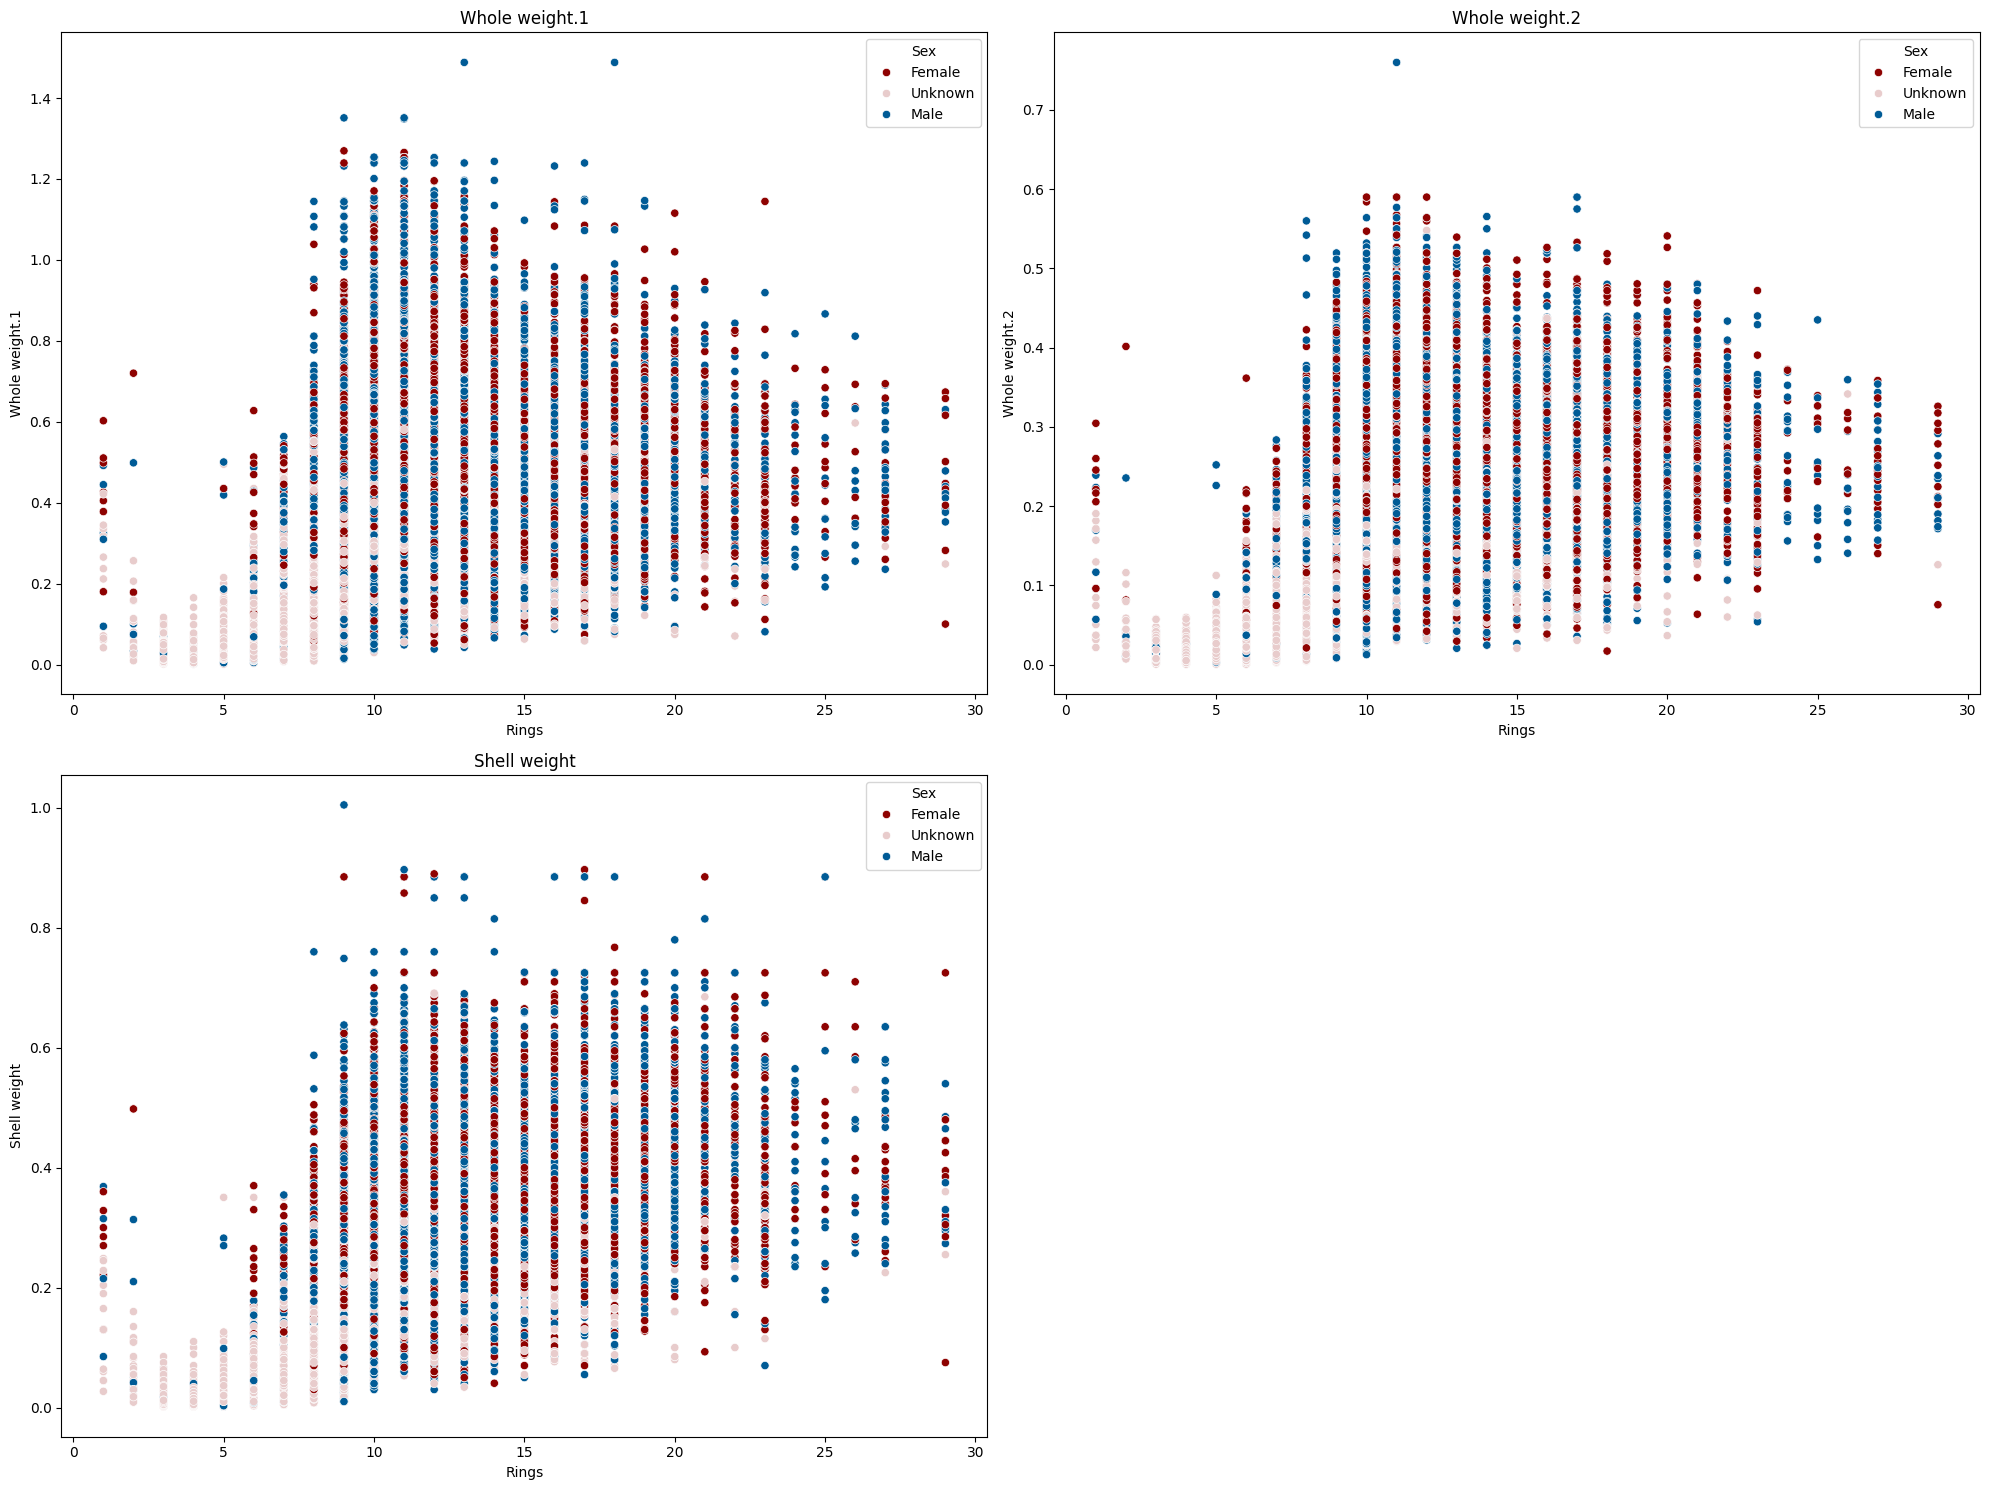

In [52]:
# Call the function with numerical columns list
scatter_plot(num_cols[4:])

Inference:
1. The Above Plot have strong positive relation with the Target Rings.

In [57]:
import warnings as w
w.filterwarnings('ignore')
def scatter_plot(col_list):
    plt.figure(figsize=(20, 15))
    for idx, val in enumerate(col_list):
        plt.subplot(2, 2, idx + 1)
        colors = ['#8e0201', '#e8cccc', '#005b96']
        if val != 'Rings':
            sns.distplot(
                x=train_data[val],
                color=colors[0]
            )

            plt.title(val) 
        else:
            plt.delaxes(plt.gca())  

    plt.tight_layout()  
    plt.show()

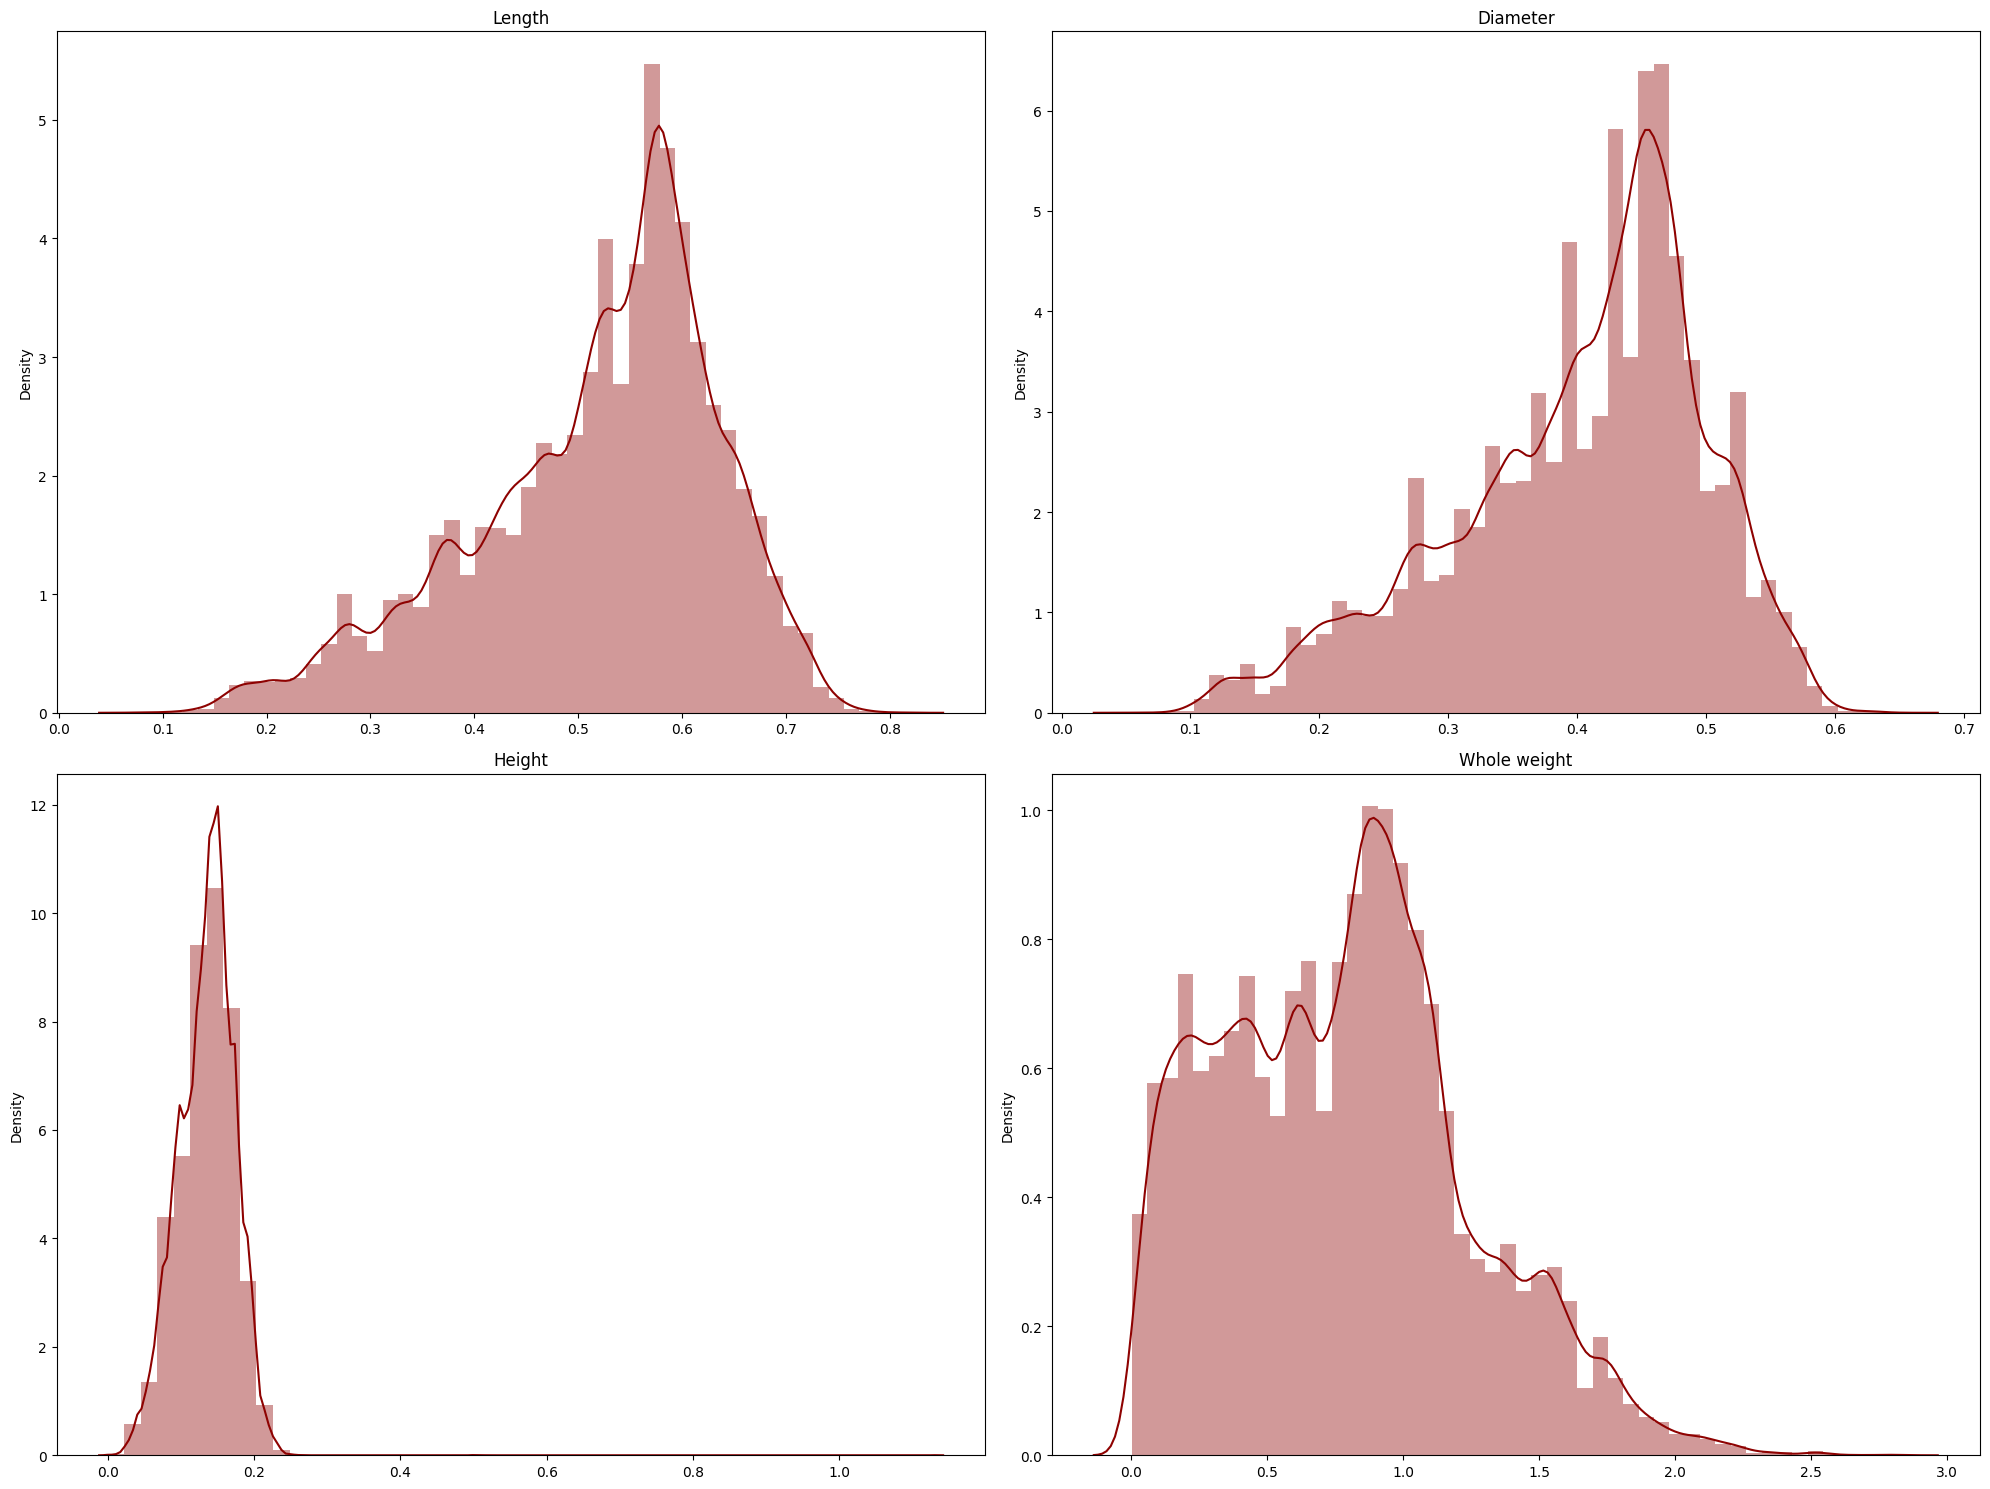

In [58]:
# Call the function with numerical columns list
scatter_plot(num_cols[0:4])

Inferences:
1. Features like Height, Diameter are Left Skewed. Presence of Negative Outliers.
2. Features like Whole Weight, Density are Right Skewed. Presence of Positive Outliers.
3. From the above Plot non of them have a Normal Distribution

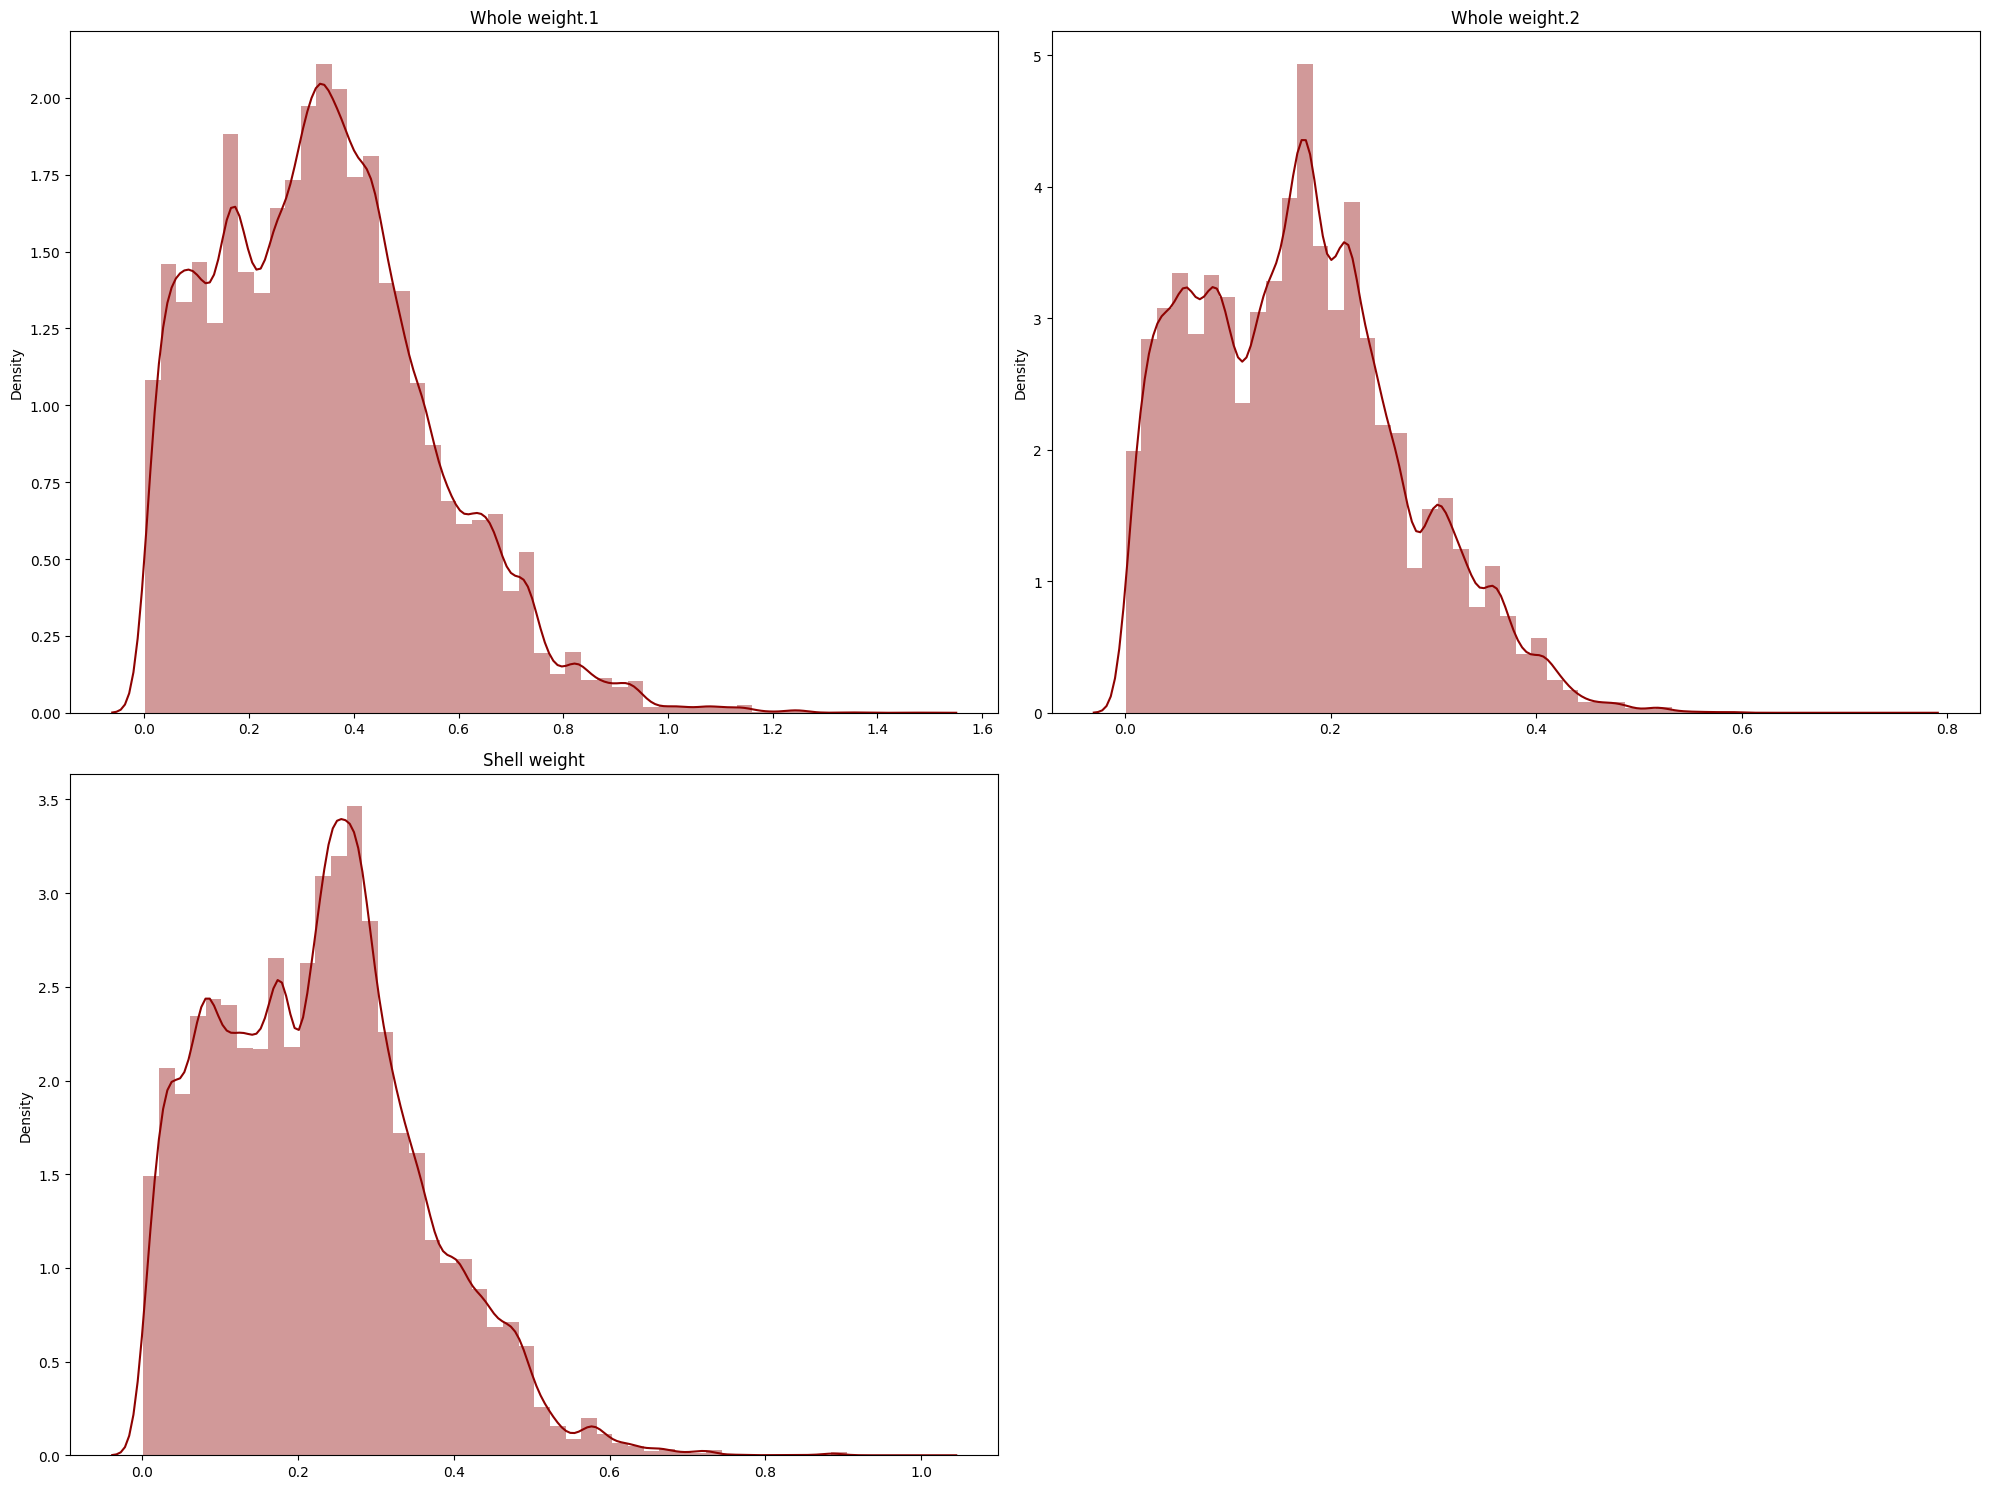

In [59]:
# Call the function with numerical columns list
scatter_plot(num_cols[4:])

Inferences:
1. From the plot above they are Right Skewed. Presence of Positive Outliers.
2. From the above Plot non of them have a Normal Distribution

Inferences:
1. Features like Length, Diamtere have Negative values for Skewness.
2. The Raminign Features have very high Positive value for Skewness.

3. Outlier Detection

In [85]:
def box_plot(col_list):
    plt.figure(figsize=(20, 15))
    for idx, val in enumerate(col_list):
        plt.subplot(2, 2, idx + 1)
        sns.boxplot(
            x= train_data[val],
            palette=colors
        )

        plt.title(f'Boxplot Distribution of {val}')
        plt.tight_layout()
    plt.show()

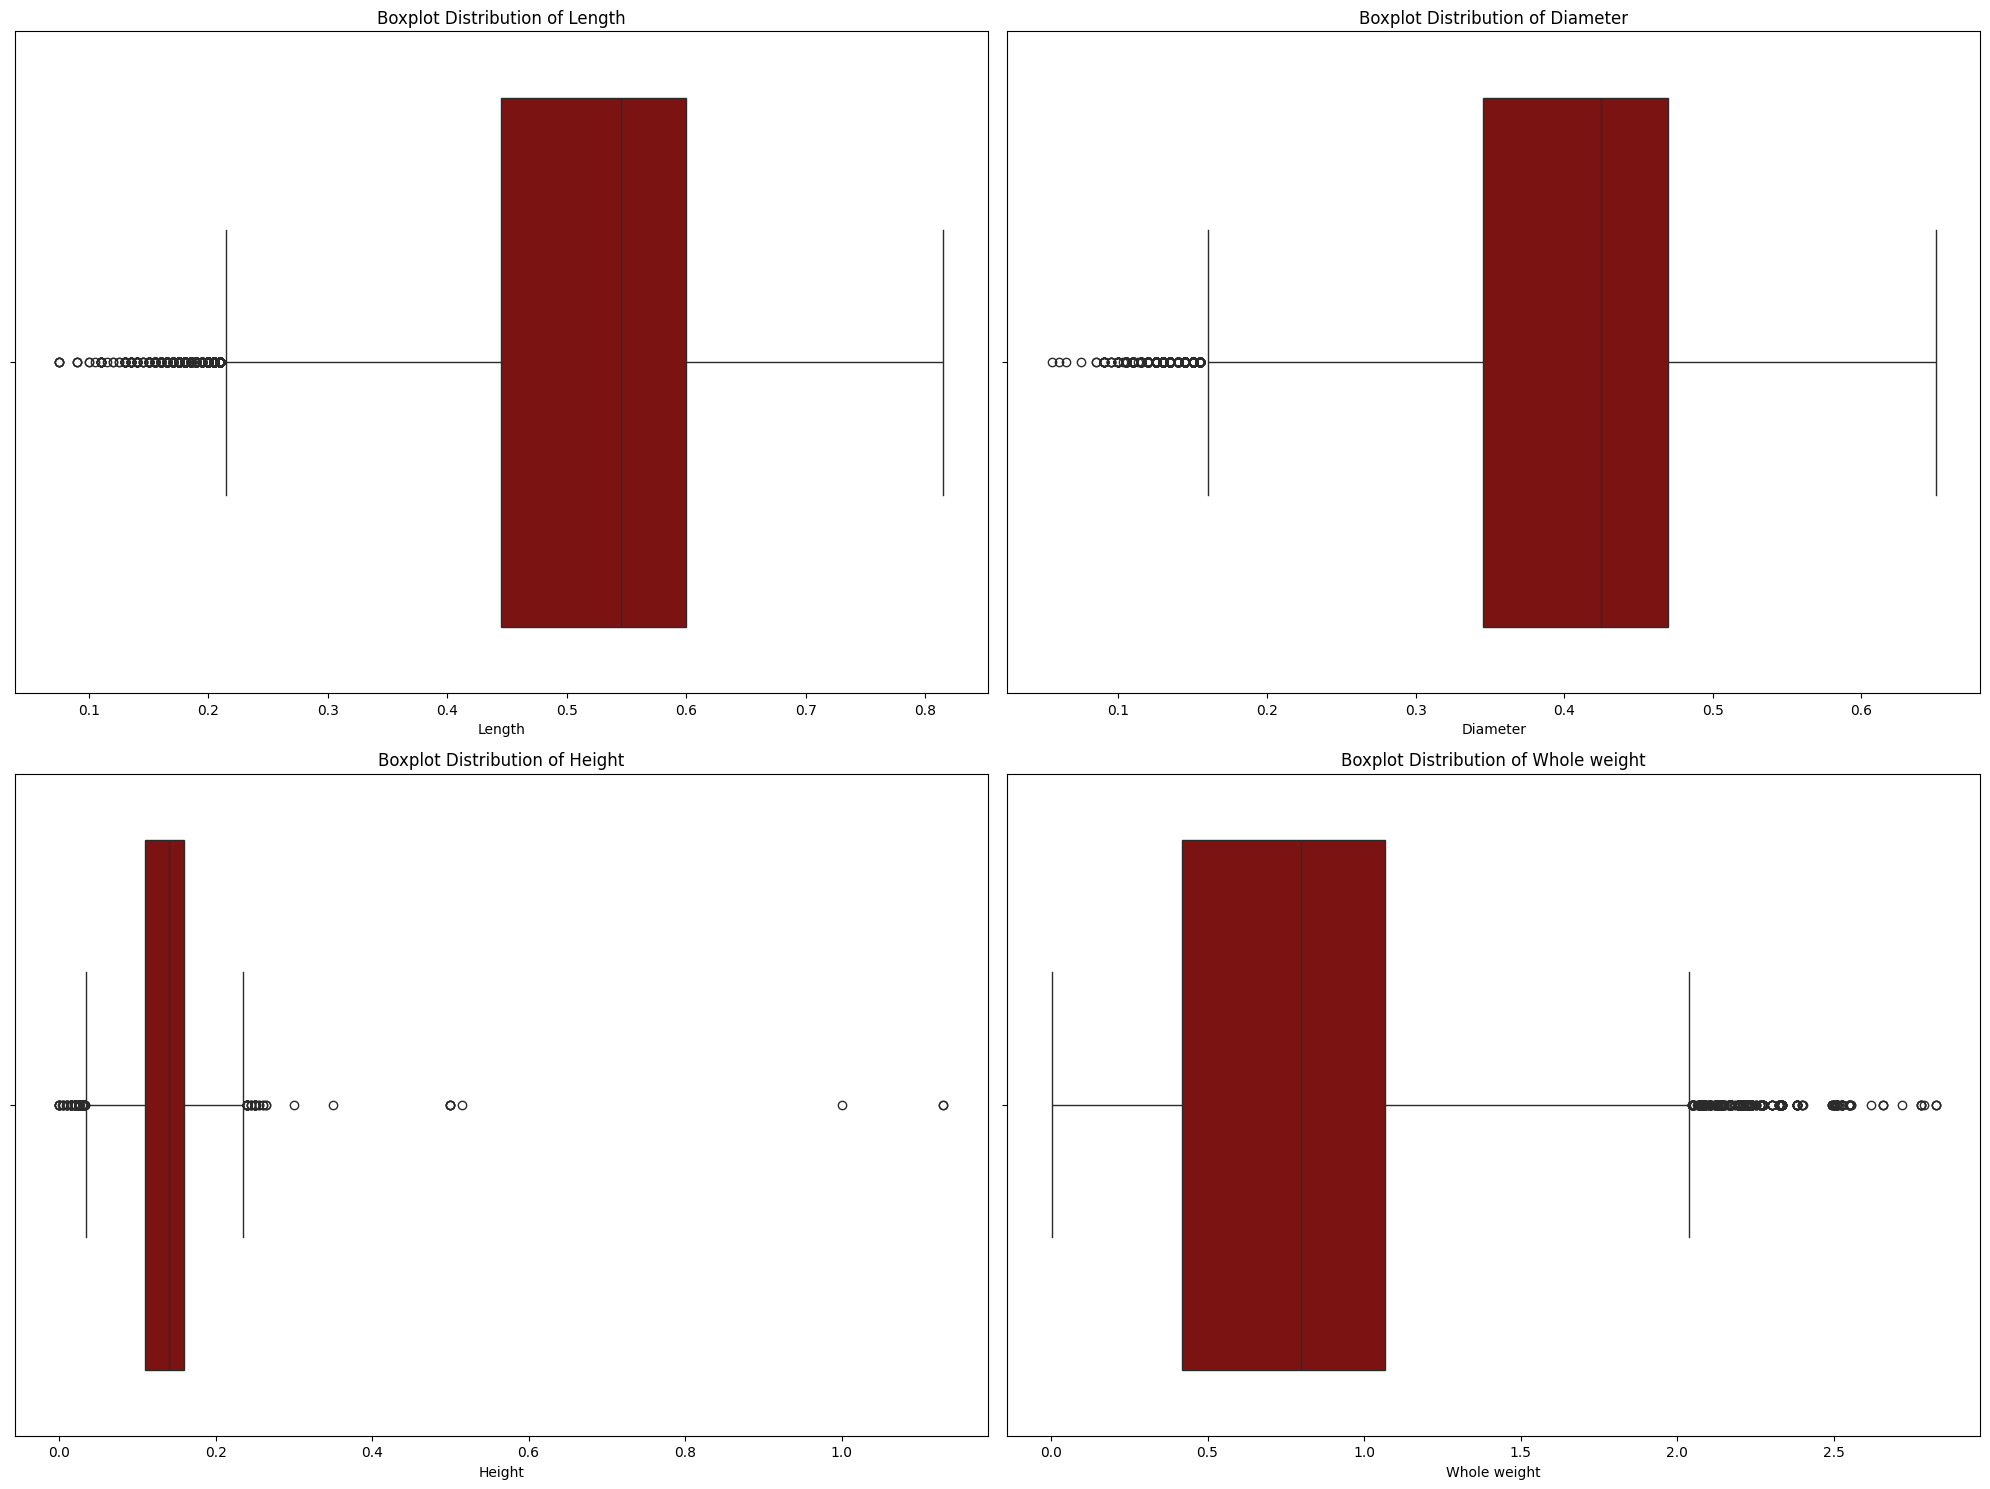

In [86]:
box_plot(num_cols[0:4])

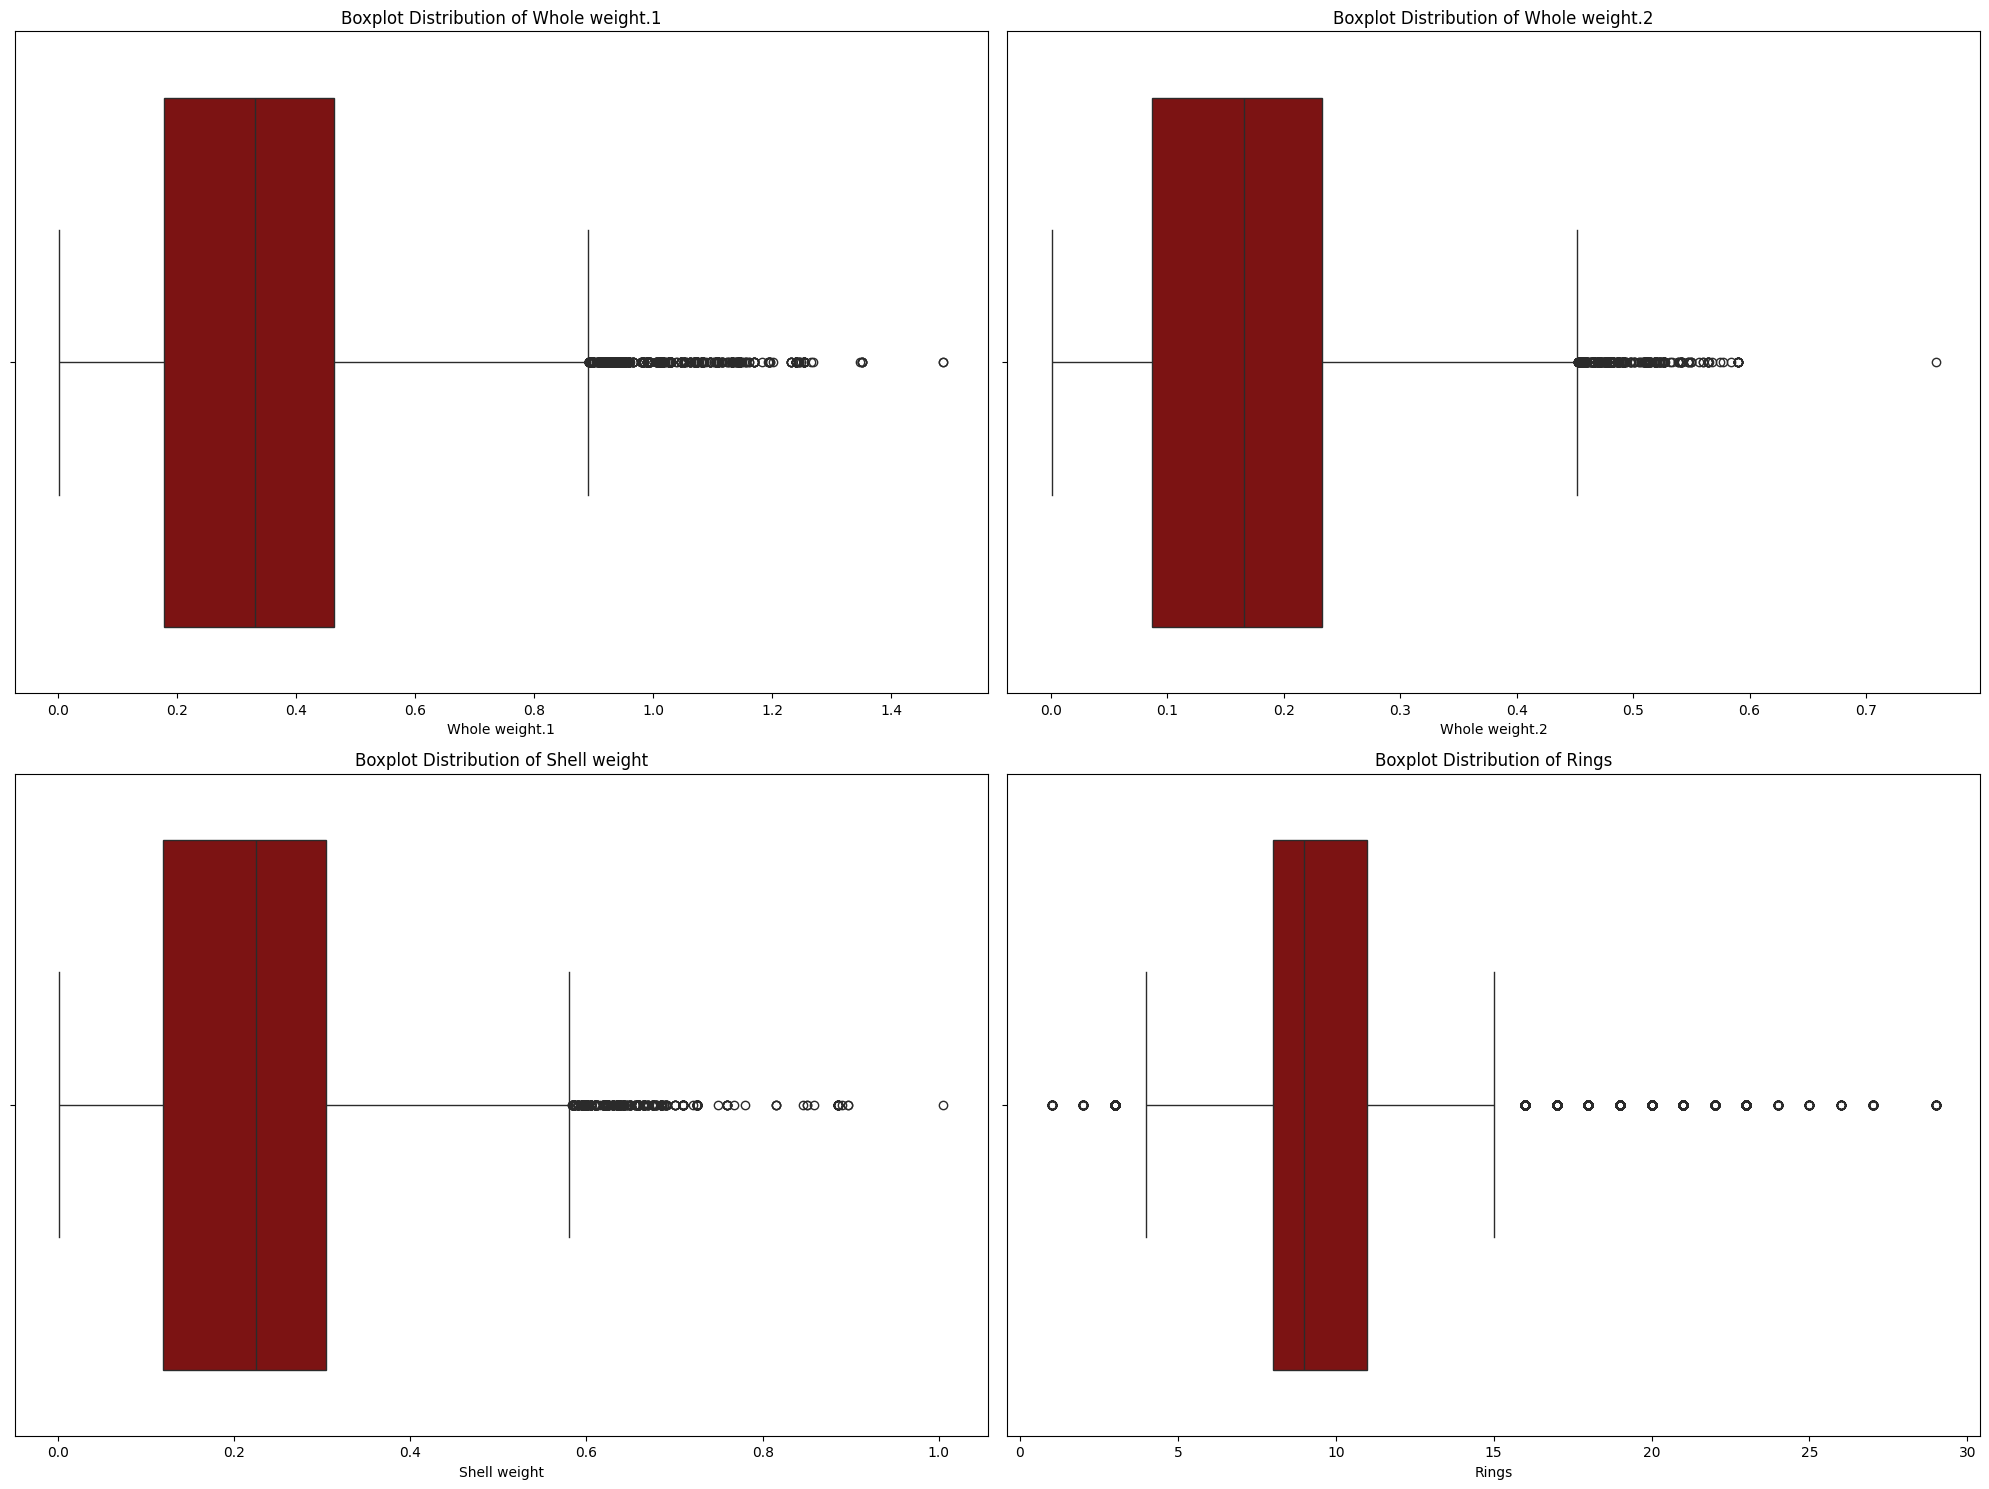

In [87]:
box_plot(num_cols[4:])

4. Handling Outliers

In [121]:
def handle_outliers(df):
    outliers = {}

    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # Check if column is numerical
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1

            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            outlier_values = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

            # Store outlier information in dictionary
            outliers[col] = outlier_values

            # Calculate percentage of outliers
            percentage_outliers = round(len(outlier_values) / len(df) * 100, 4)
            print(f"Percentage of outliers in '{col}': {percentage_outliers}%", '\n')
          
            # Remove outliers from DataFrame
            df = df[~df[col].isin(outlier_values)]

    return df

In [123]:
train_df2= train_data.copy()

In [124]:
train_data = handle_outliers(train_data)

Percentage of outliers in 'Length': 1.6112% 

Percentage of outliers in 'Diameter': 0.4173% 

Percentage of outliers in 'Height': 0.0822% 

Percentage of outliers in 'Whole weight': 0.7% 

Percentage of outliers in 'Whole weight.1': 0.6811% 

Percentage of outliers in 'Whole weight.2': 0.1486% 

Percentage of outliers in 'Shell weight': 0.6788% 

Percentage of outliers in 'Rings': 5.6796% 



5. Correlation Matrix

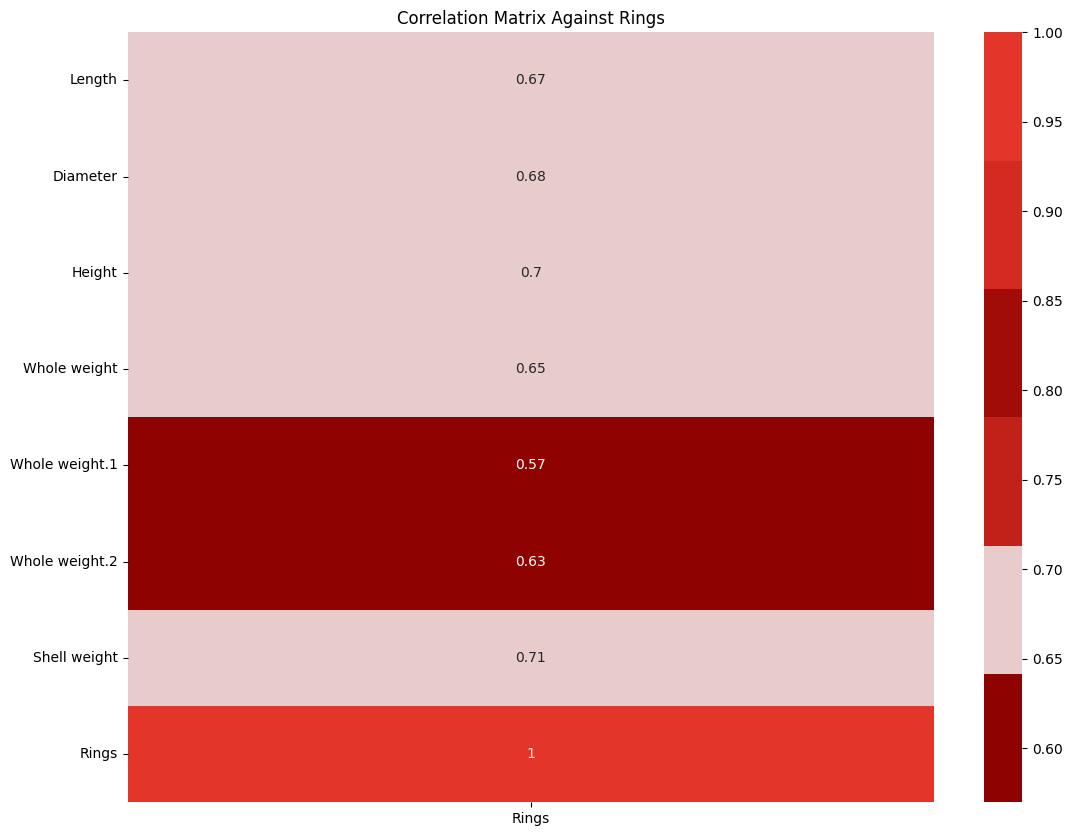

In [127]:
#checing the correlation of the features with the target 
corr_target = train_data.corr(numeric_only=True)[['Rings']]

plt.figure(figsize=(13,10))
sns.heatmap(corr_target, annot=True, cmap=colors)
plt.title('Correlation Matrix Against Rings')
plt.show()

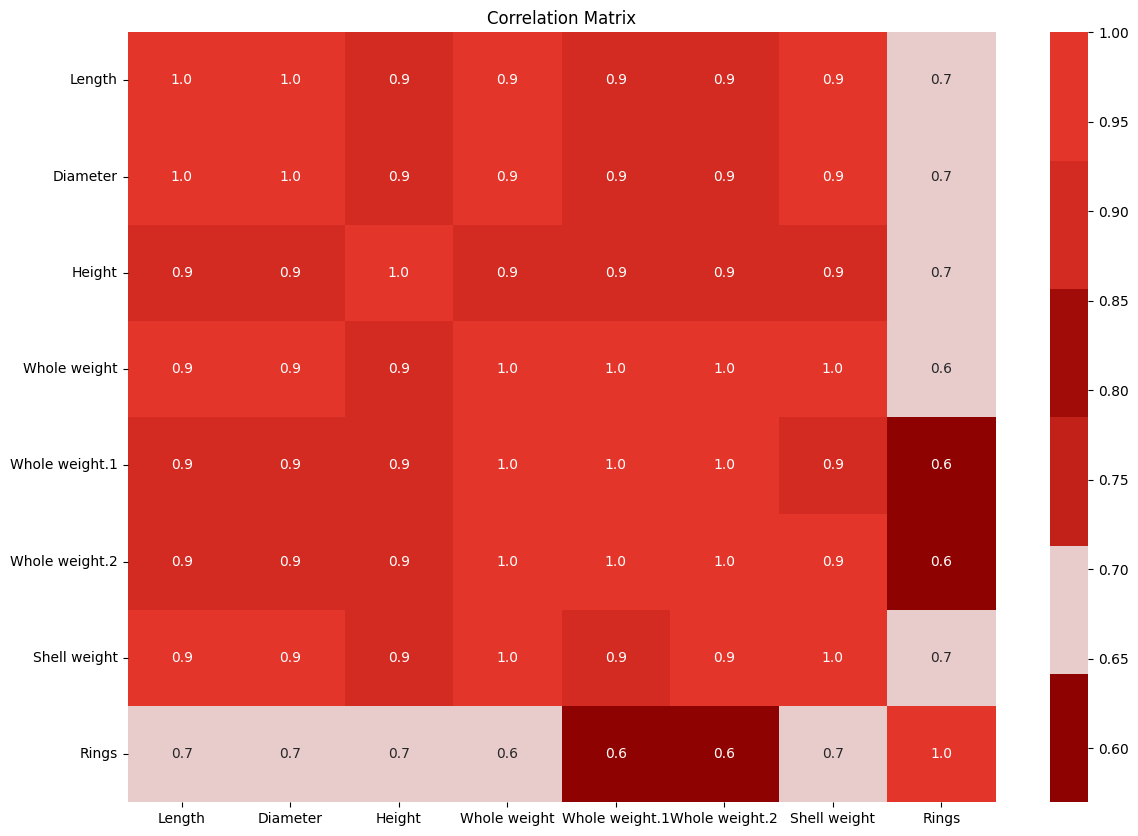

In [129]:
#overall correaltion matrix
plt.figure(figsize=(14,10))
sns.heatmap(
    train_data.corr(numeric_only=True), annot=True, cmap=colors, fmt='.1f'
)
plt.title('Correlation Matrix')
plt.show()

#### <b> Feature Engineering </b>

1. Total Weights

In [130]:
train_data['Total_Weight']= (train_data['Whole weight'] + train_data['Whole weight.1'] + train_data['Whole weight.2'] + train_data['Shell weight'] )
test_data['Total_Weight']= (test_data['Whole weight'] + test_data['Whole weight.1'] + test_data['Whole weight.2'] + test_data['Shell weight'] )

2. Surface Area

In [131]:
import math
train_data['Surface_Area']= ( (2 * math.pi * (train_data['Diameter']/2)**2 )  + (2 * math.pi * (train_data['Diameter']/2) * train_data['Height'])  )
test_data['Surface_Area']= ( (2 * math.pi * (test_data['Diameter']/2)**2 )  + (2 * math.pi * (test_data['Diameter']/2) * test_data['Height'])  )

3. Aspect Ratio

In [132]:
train_data['Aspect_Ratio']= (train_data['Diameter'] / train_data['Height'])
test_data['Aspect_Ratio']= (test_data['Diameter'] / test_data['Height'])

4. Shell Weight ratio

In [133]:
train_data['Shell_Weight_Ratio']= (train_data['Shell weight'] / train_data['Total_Weight'])
test_data['Shell_Weight_Ratio']= (test_data['Shell weight'] / test_data['Total_Weight'])

#### <b> Data Preprocessing 2 </b>

In [136]:
train_df2= train_data.copy()

1. Checking Skewness level

In [181]:
def plot_skewness(col_list):
    skewness_values = [train_data[val].skew() for val in col_list]
  
    pairs = zip(col_list, skewness_values)

    # Sort the pairs based on skewness values in descending order
    sorted_pairs = sorted(pairs, key=lambda x: x[1], reverse=True)

    sorted_col_list = [pair[0] for pair in sorted_pairs]
    sorted_skewness_values = [pair[1] for pair in sorted_pairs]


    # Define colors and palette
    colors = ['#8e0201', '#e8cccc'] 
    palette = [colors[0] if val > 0 else colors[1] for val in skewness_values] 


    plt.figure(figsize=(10, 6))
    ax=sns.barplot(x=sorted_col_list, y=sorted_skewness_values, palette=palette)
    plt.title('Skewness of Numerical Columns')
    plt.xlabel('Column')
    plt.ylabel('Skewness')
    plt.xticks(rotation=45)

    #adding annotations
    for i, v in enumerate(sorted_skewness_values):
        ax.text(i, v + 0.01, str(round(v, 2)), ha='center', va='bottom', color='red')
 
    plt.show()

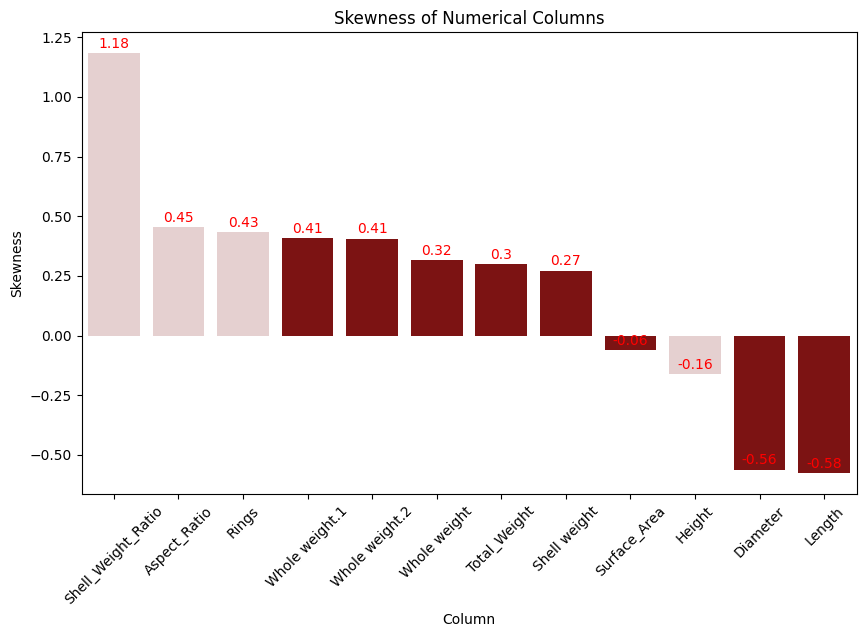

In [182]:
#selecting numerical columns
num_cols = train_data.select_dtypes(include=np.number).columns.tolist()
# Call the function with numerical columns list
plot_skewness(num_cols)

In [183]:
 # Apply log transformation to fix skewness
for col in num_cols:
    if train_data[col].skew() > 0:
        train_data[col] = np.log1p(train_data[col])

In [198]:
num_cols.remove('Rings') 
# Apply log transformation to fix skewness
for col in num_cols:
    if (num_cols != 'Rings') & (test_data[col].skew() > 0):
        test_data[col] = np.log1p(test_data[col])

#### <b> Model Building </b>

In [218]:
#changin the column orderring
columns=train_data.columns.tolist()
columns.remove('Rings')
columns.append('Rings')

In [221]:
final_columns =columns

train_data =train_data[final_columns]

In [224]:
#final_df 
final_df = train_data.copy()

#data splitting
train_data, test_data = train_test_split(final_df, test_size=0.2, random_state=42)

In [227]:
#Custom Dataset Class
class CustomDataset(Dataset):
    #initalize the data
    def __init__(self, data):
        self.data = data
    
    #getting the length of the data
    def __len__(self):
        return len(self.data)
    
    #separating the fetaures from the target
    def __getitem__(self, idx):
        x= torch.tensor(
            self.data.iloc[idx, : -1], dtype=torch.float32
        )
        y= torch.tensor(
            self.data.iloc[idx, -1], dtype=torch.float32
        )
        #returning the results
        return x, y
    